# 📜Summary
**Introduction:** The client is a large grocery store in Ecuador that wants to be more efficient in stocking inventory.

**Problem:** If inventory is oversupplied, unsold items will go to waste and are cost to the grocery. If inventory is undersupplied, there wouldn't be enough items to sell that meets demand and they would miss the opportunity to earn more money.

**Hypothesis:** If we are able to know how much inventory to supply in a given day, then we would minimize the cost of oversupplying items that does not sell and goes to waste. And maximizing revenue by having enough supply of items that we know will be in demand.

**Goal:** To predict and forecast the inventory needed to meet the demand of market.

-----
[Kaggle](https://www.kaggle.com/code/fiftythirtyfour/store-sales/)

# 🪴Selfnotes
📜Understanding the problem is an excercise. It allows you to deconstruct problems into its most fundamental components and look at things individually. Don't focus on fixing the problem but focus on the process of fixing the problem. Put things into stages and figure out your style. Explain the Introduction, state the problem, make the hypothesis and declare the goal. Then do the work. Do this many times and you will be able to tackle everything then you can conquer the world.

🤓You need to be comfortable at being curious. Remove any constraints that prevents you from writing down your thoughts on paper or doing a simple graph to check if your idea is valid. Understand that you are 2 persons. The first is the dog that needs to catch the ambulance but has no idea what to do with it when it catches it. The second is the ducks-in-a-row guy that wants everything to be in order before actually doing something. These 2 needs to work together. 2nd guy must tell the 1st guy which direction to go and makes notes. The 1st guy needs to run as fast a possible. Don't let it concern himself of the busy-work. Just keep running, knowing that 2nd guy is there to clean up after him.

🤖Machine Learning is just feature engineering. Andrew Ang said that after he defeated fire-lord Tuko. You have to keep everything simple. ML is just a big calculator, where you do inputs and it does outputs. To make a good calculator, you just need to make the blue lines look similar to the orange lines. Bend it, make it less squigglely. Always graph your residuals. Don't rely on the numbers because they were made for robots. You are human. You know it will rain because the clouds are dark. And you need to choose Linear Regression over the advance stuff because you will learn so much more on these basic models.
    

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.display.max_rows = 400
import warnings
warnings.filterwarnings('ignore')

## Load
df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv')
transactions = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/transactions.csv')
stores = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/stores.csv')

## Clean
transactions['date'] = pd.to_datetime(transactions['date'])
stores['cluster'] = stores['cluster'].astype(str)
store_type = dict(zip(stores['store_nbr'], stores['type']))

def cleanData(a):
    a['date'] = pd.to_datetime(a['date'])
    a['year'] = a['date'].dt.year
    a['weekname'] = a.date.dt.day_name()
    a['weeknum'] = a['date'].dt.isocalendar().week
    a['dayofyear'] = a['date'].dt.strftime('%j').astype(int)
    a['store_type'] = a['store_nbr'].map(store_type)
#     a['onpromotion'] = np.where(a['onpromotion'] < 100, 0, a['onpromotion'])
    return a

df = cleanData(df)

## Organize
target = 'sales'
cat = [x for x in df.columns if df.dtypes[x] == 'object']
num = [x for x in df.columns if df.dtypes[x] in ('int64', 'float64')]
num.remove('id')
num.remove('sales')

## train test split
train = df.loc[df['date'].dt.year != 2017]
test = df.loc[df['date'].dt.year == 2017]

# 🤓Data

# > Correlation

In [2]:
train.corr(numeric_only=True)[target].sort_values(ascending=False)

sales          1.000000
onpromotion    0.379903
id             0.083456
year           0.077355
store_nbr      0.037881
dayofyear      0.034132
weeknum        0.032397
Name: sales, dtype: float64

# > Explore

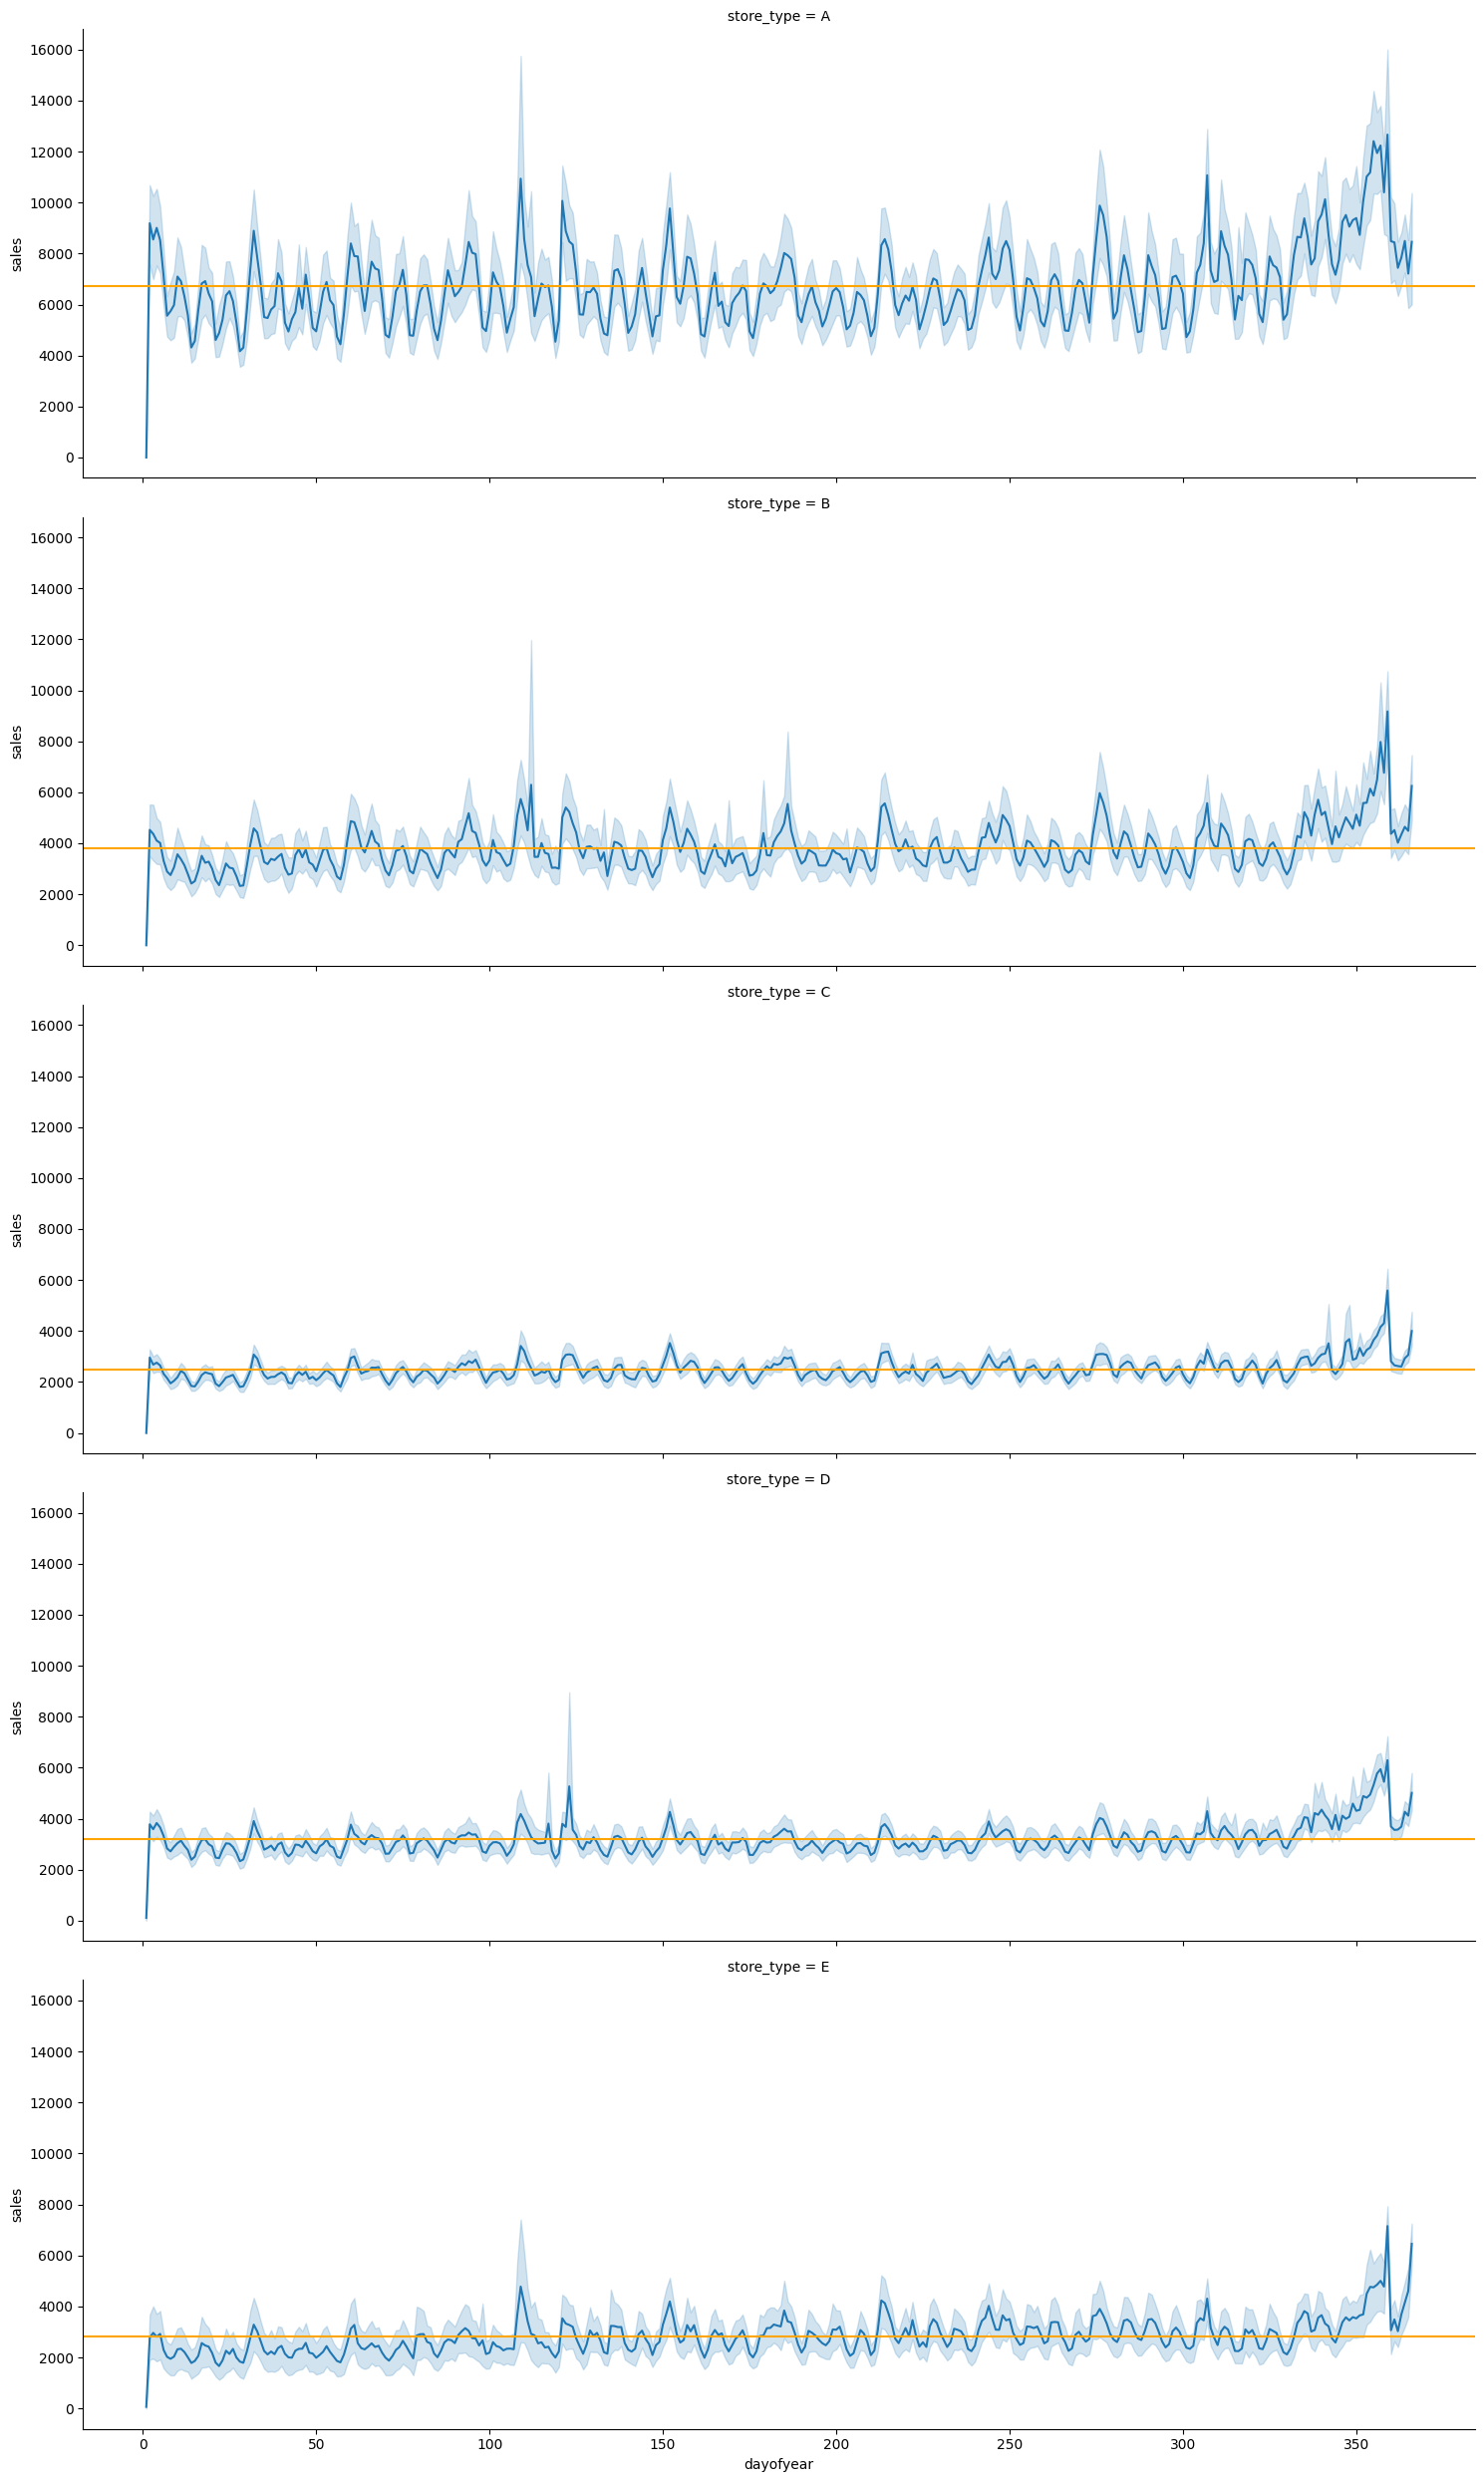

In [3]:
d = train.query("family== 'GROCERY I'") ## Focus on GROCERY I
d['store_type'] = d['store_nbr'].map(store_type)
g = d.groupby('store_type') ## Use groupby as an function object
m = g[target].mean() ## Easier to get means

h = sns.relplot(d, x='dayofyear', y=target
                , row='store_type', row_order=list('ABCDE') ## Graph timeseries by store_type
                , kind='line', aspect=3)

## Since I have relplot as an FacetGrid, I can get the axes
## individually and map mean as an axhline for each
## store_type.
for ax, mean in zip(h.axes.flat, m):
    ax.axhline(y=mean, color='orange')

plt.show()

## The goal is to be comfortable at looking for a category
## that fits the target. And see if it is worth adding
## into the model.

# > Low volume low volatility items
I need to figure out how to add zeros and ones to items that are insignificant like Books. The model is predicting variability that are applicable to the high volume items like groceries but in reality books are 1s and 0s. How?

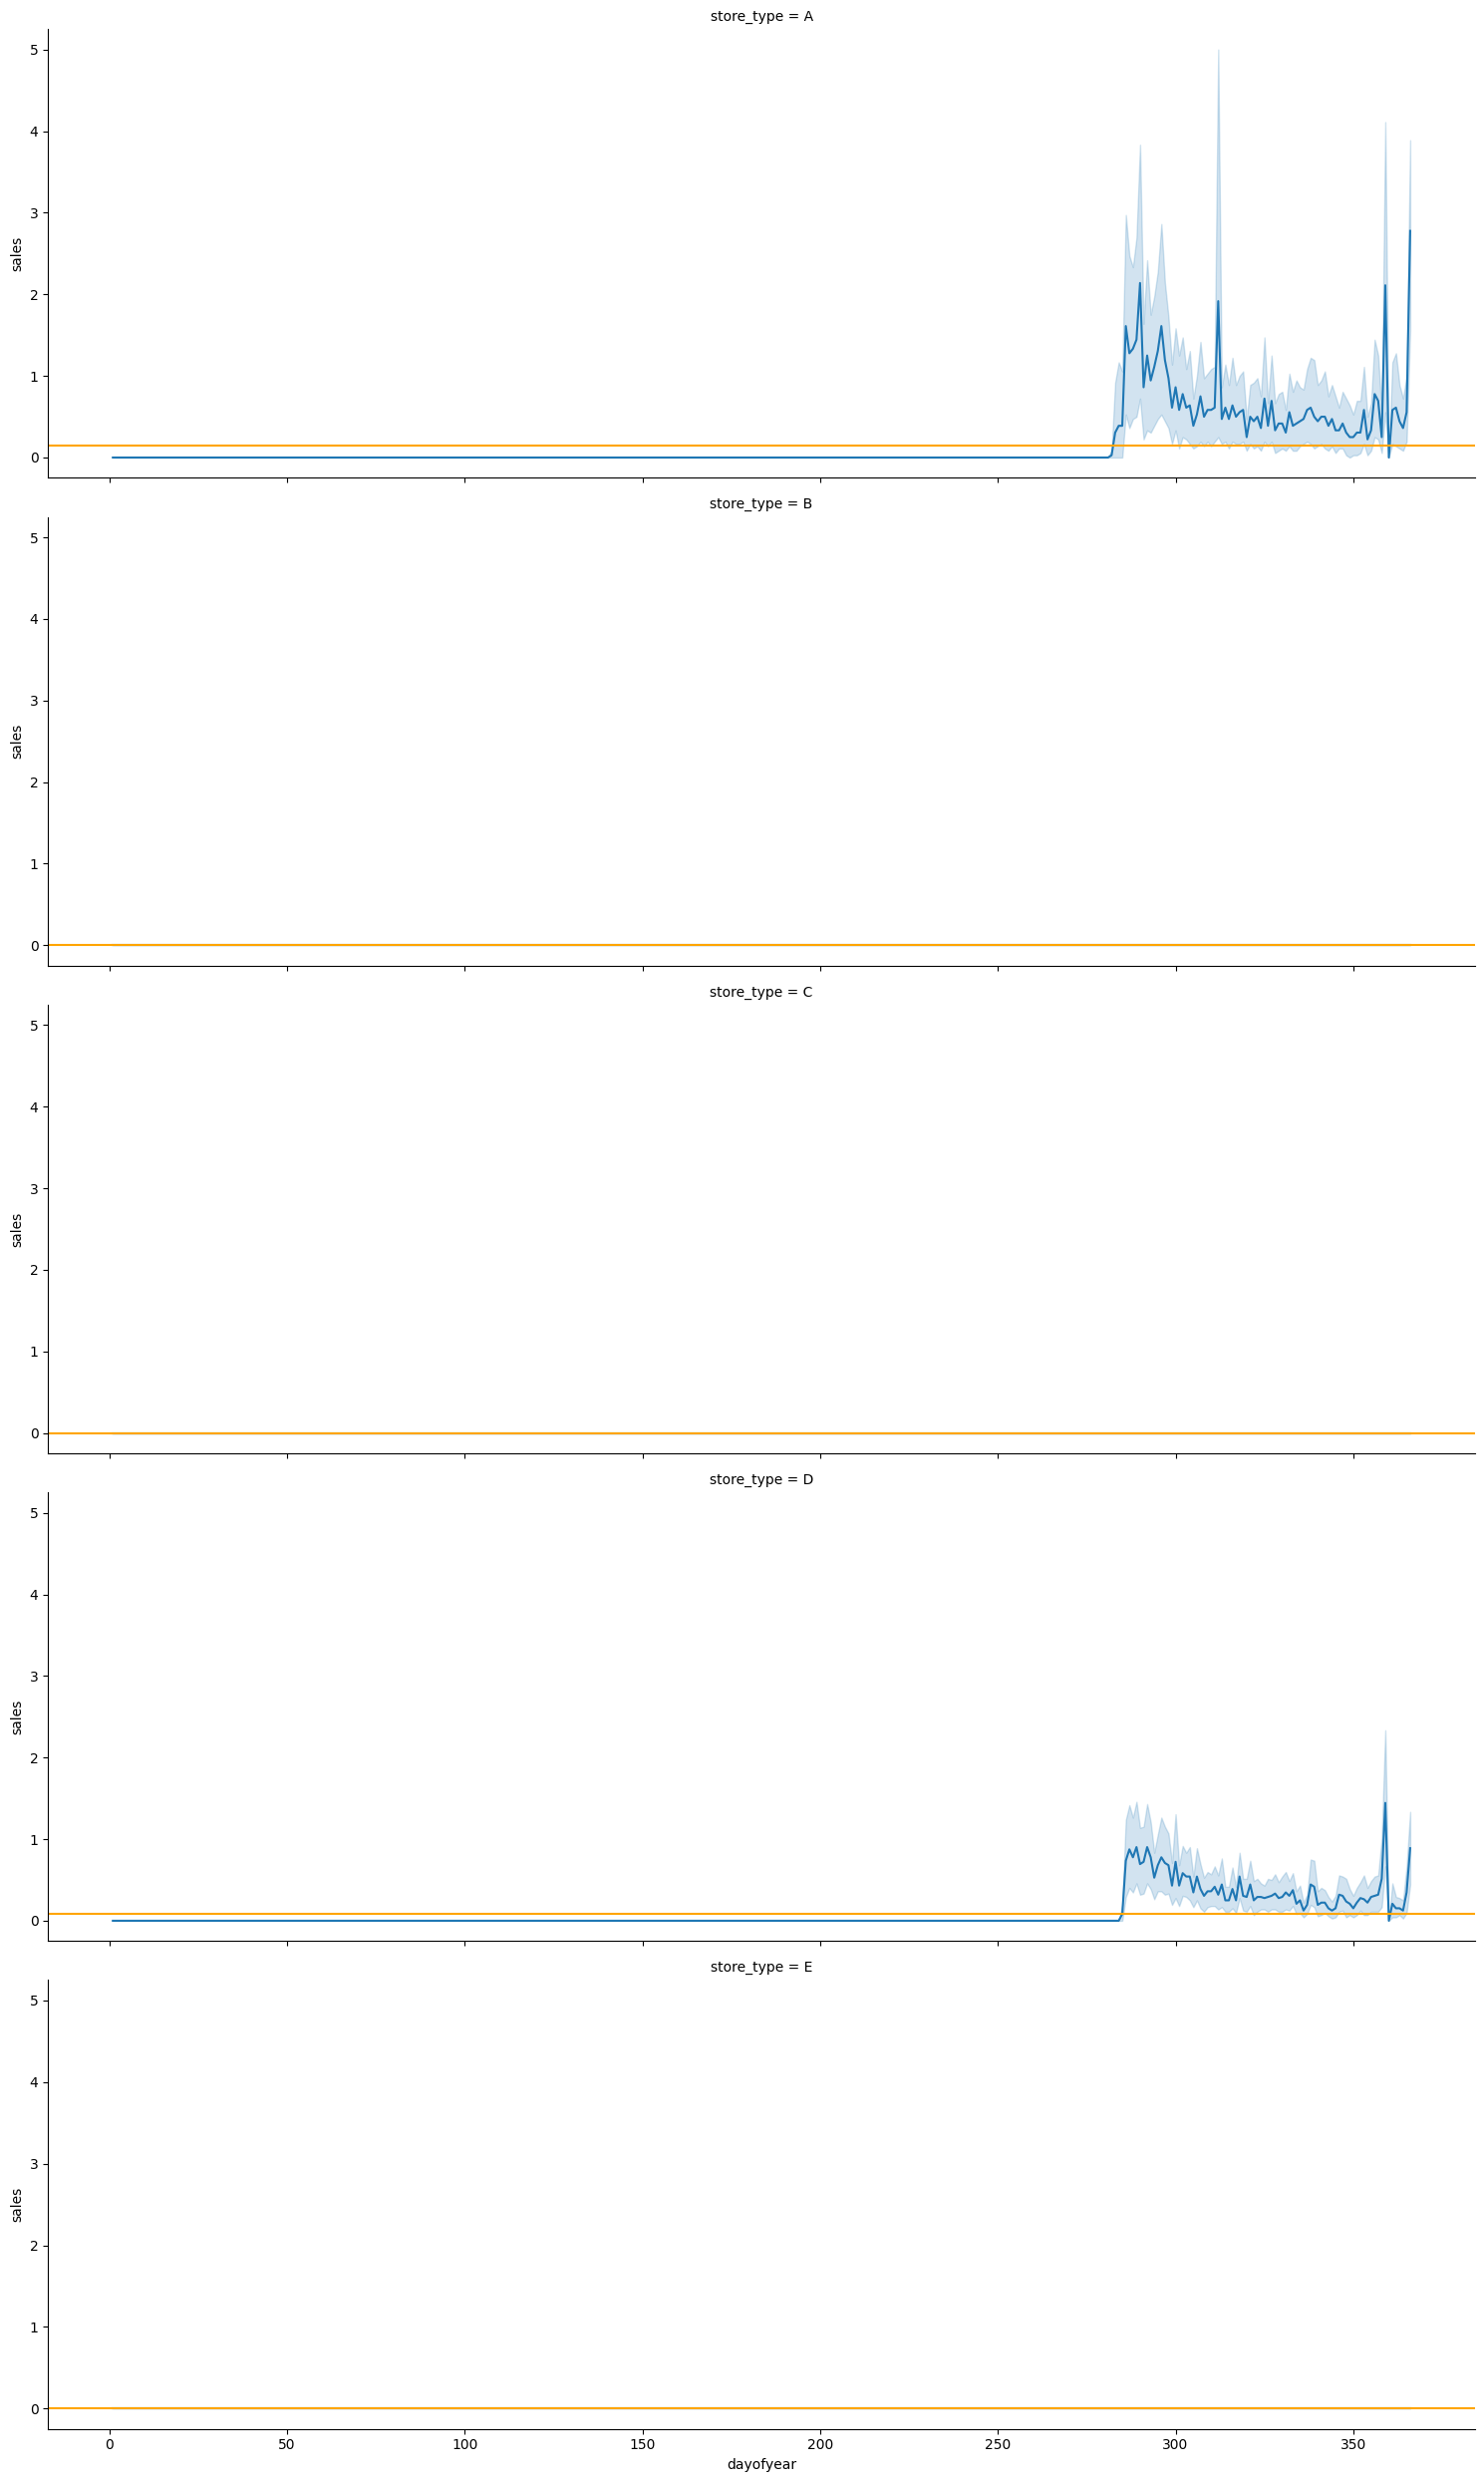

In [4]:
d = train.query("family== 'BOOKS'")
d['store_type'] = d['store_nbr'].map(store_type)
g = d.groupby('store_type')
m = g[target].mean()

h = sns.relplot(d, x='dayofyear', y=target
                , row='store_type', row_order=list('ABCDE')
                , kind='line', aspect=3)

for ax, mean in zip(h.axes.flat, m):
    ax.axhline(y=mean, color='orange')

plt.show()

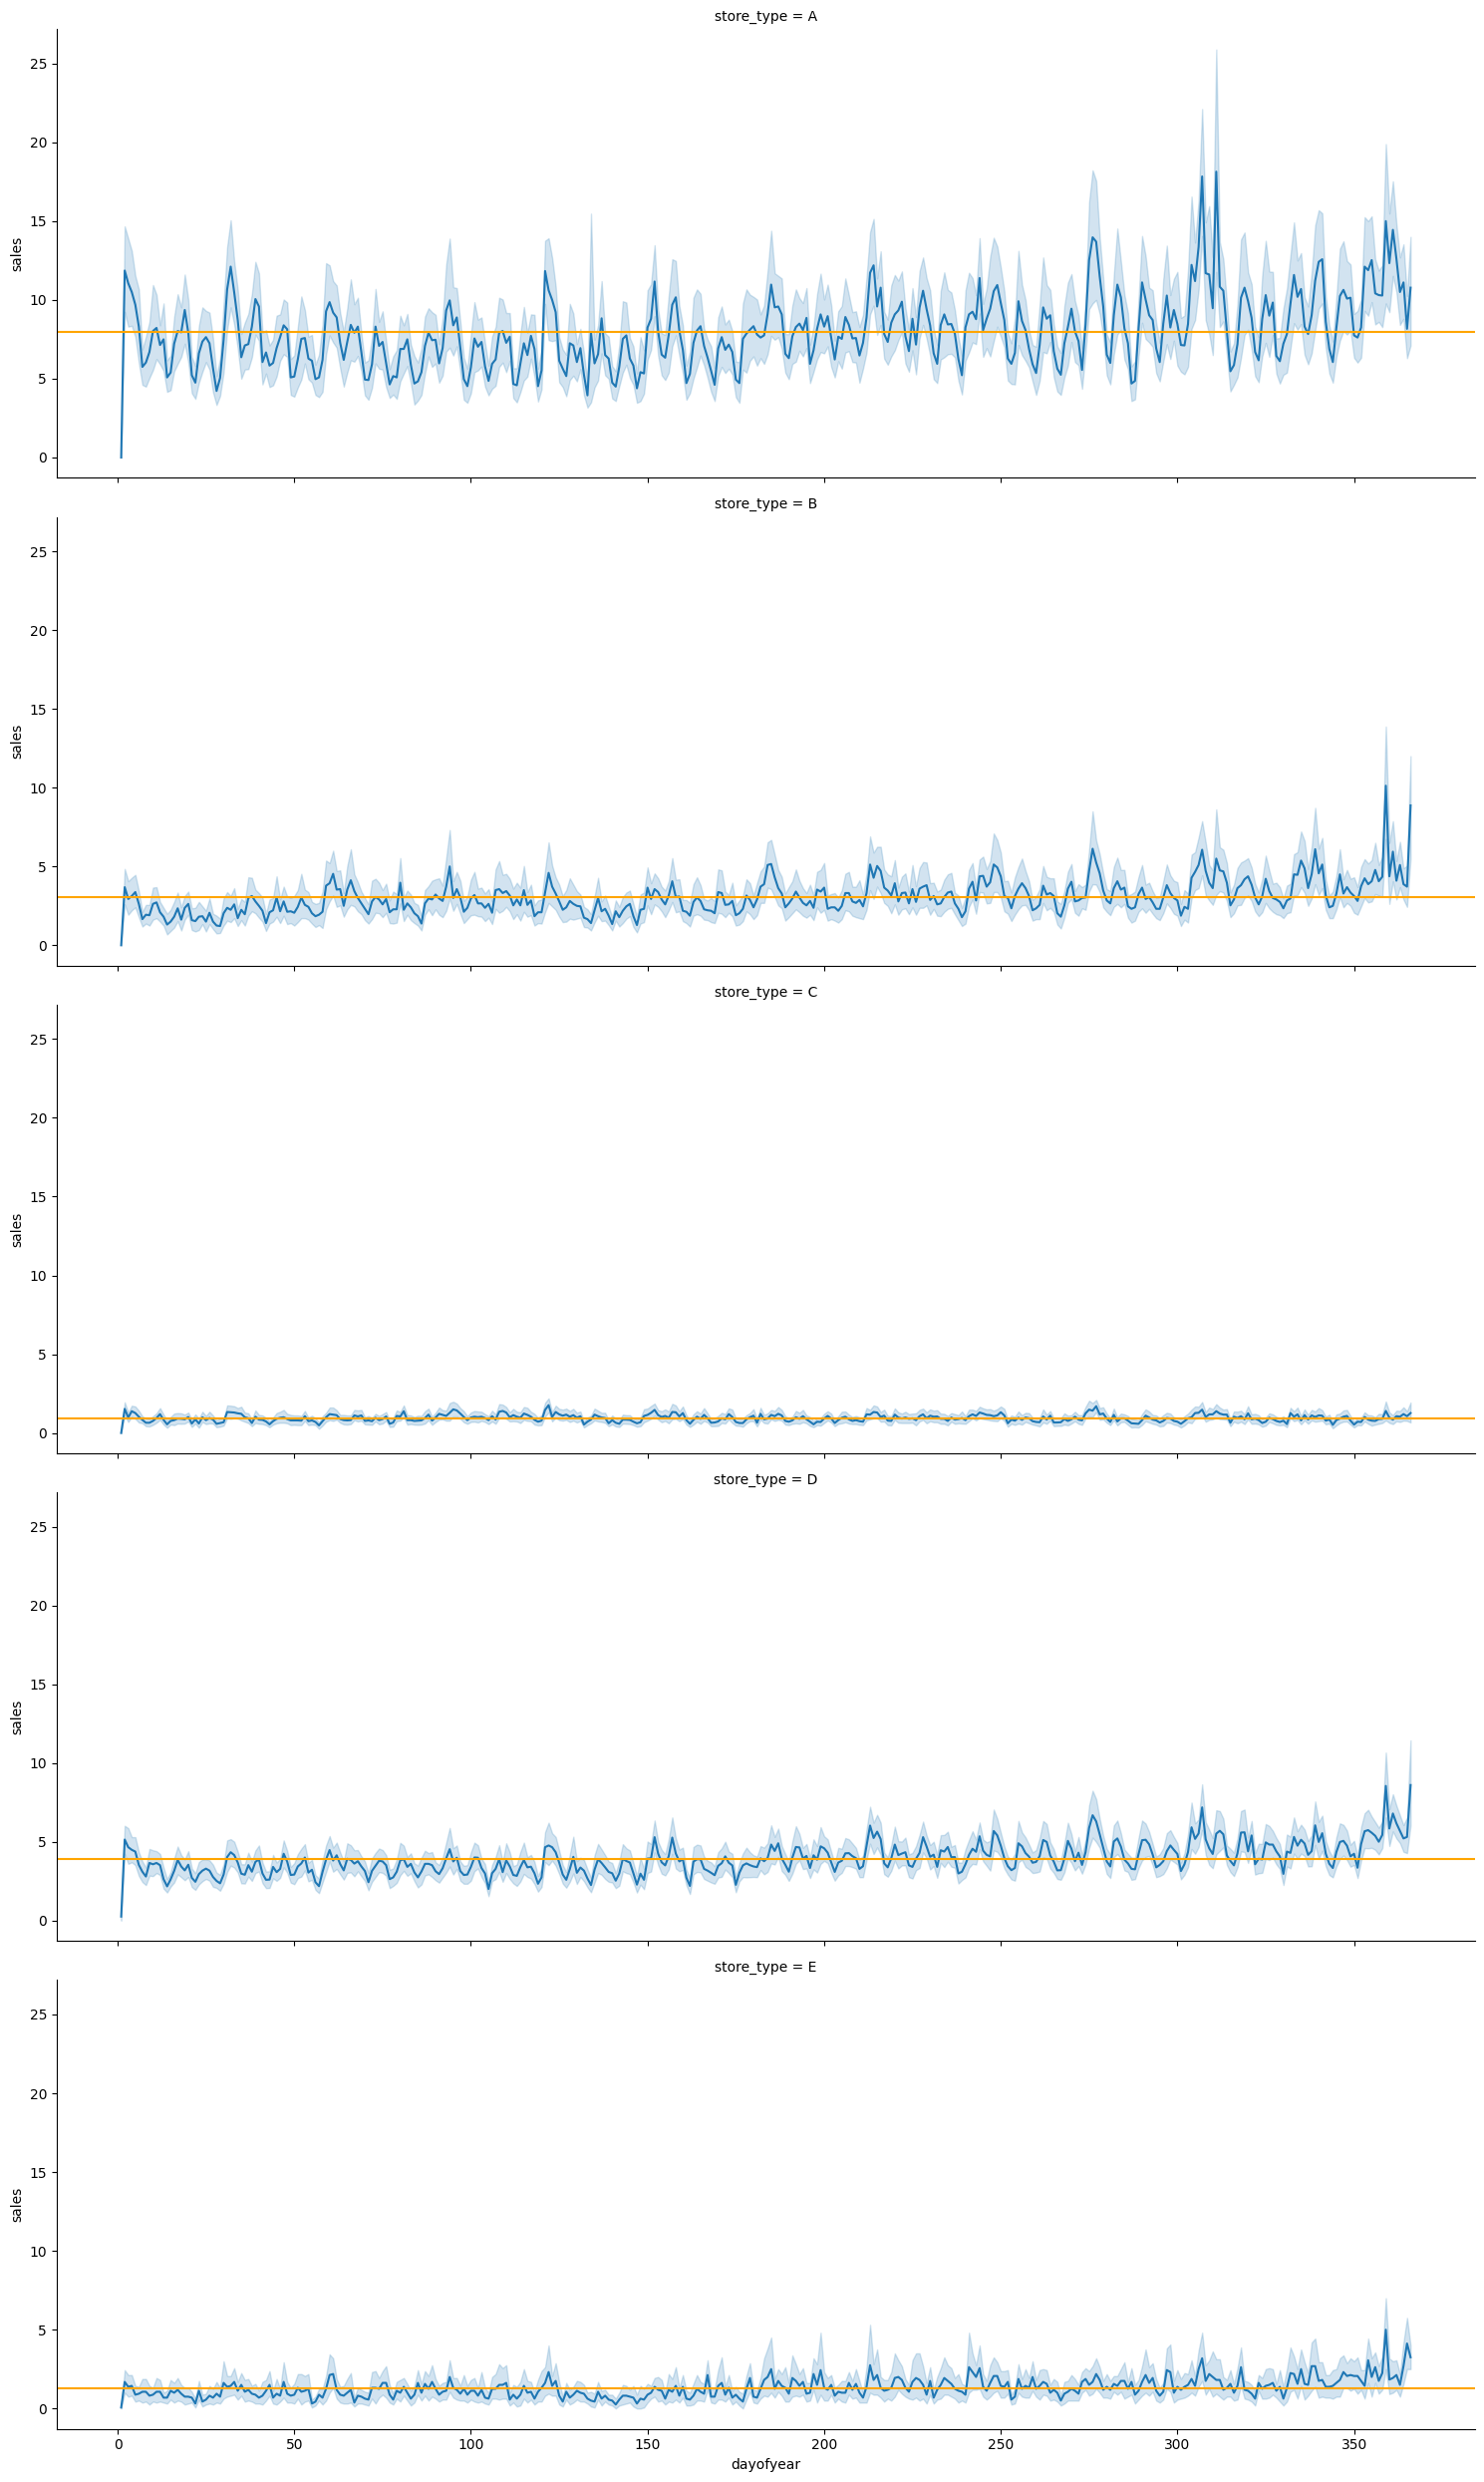

In [5]:
d = train.query("family== 'BEAUTY'")
d['store_type'] = d['store_nbr'].map(store_type)
g = d.groupby('store_type')
m = g[target].mean()

h = sns.relplot(d, x='dayofyear', y=target
                , row='store_type', row_order=list('ABCDE')
                , kind='line', aspect=3)

for ax, mean in zip(h.axes.flat, m):
    ax.axhline(y=mean, color='orange')

plt.show()

# > Items with largest volume and volatility
Type A stores have more data. Will focus on this. Now, I need to see which products have the largest volume and deviations. The products that have low volume and does not have big swings, I will just use the average or zeros.

In [6]:
g = train.query('store_type=="A"')
g = g.groupby('family')[target].agg(['sum', 'std'])
g.sort_values(['sum'], ascending=False )

,sum,std
family,,
GROCERY I,8.795437e+07,4002.821565
BEVERAGES,5.735129e+07,3320.277867
PRODUCE,3.531288e+07,3546.392141
CLEANING,2.368491e+07,987.190292
DAIRY,1.913834e+07,922.703547
POULTRY,1.104872e+07,562.829831
BREAD/BAKERY,1.064485e+07,480.295143
MEATS,1.041856e+07,443.761820
PERSONAL CARE,6.373462e+06,338.781103


# 🤖Model

# > Pipes

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

class DataSelect(BaseEstimator, TransformerMixin):
    
    def __init__(self, att):
        self.att = att
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = cleanData(X) ## Find this at Top.
        return X[self.att]
    
num_pp = Pipeline([
    ('dataselect', DataSelect(['onpromotion', 'weeknum']))
    , ('impute', SimpleImputer(strategy='mean'))
    , ('scaler', StandardScaler())
])

cat_pp = Pipeline([
    ('dataselect', DataSelect(['family', 'store_nbr', 'store_type', 'weekname']))
    , ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

pipe = FeatureUnion([
    ('numeric', num_pp)
    , ('cat', cat_pp)
])

pipe.fit(train)
train_pp = pipe.transform(train)
test_pp = pipe.transform(test)

# > Baseline

In [8]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

In [9]:
reg_lin = LinearRegression()
reg_lin.fit(train_pp, train[target])
np.sqrt(
    -cross_val_score(
        reg_lin, train_pp, train[target], scoring='neg_mean_squared_error').mean()
)

709.9284118193091

# > Residuals. Make orange closer to blue dots.

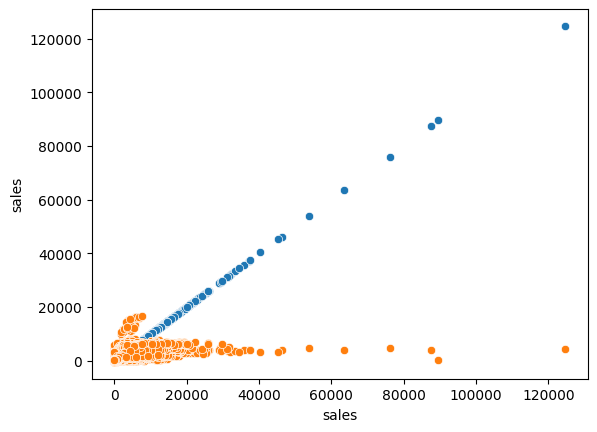

In [10]:
x = train[target]
y = reg_lin.predict(train_pp)
sns.scatterplot(x=x,y=x);
sns.scatterplot(x=x,y=y);
## improve this. you are in the right direction.

# > Predicted Demand vs Actual Sales
Why are the predictions lower than actual? I think it is because the predictions accounts for all types of stores. The lower volume stores are dragging the average down.

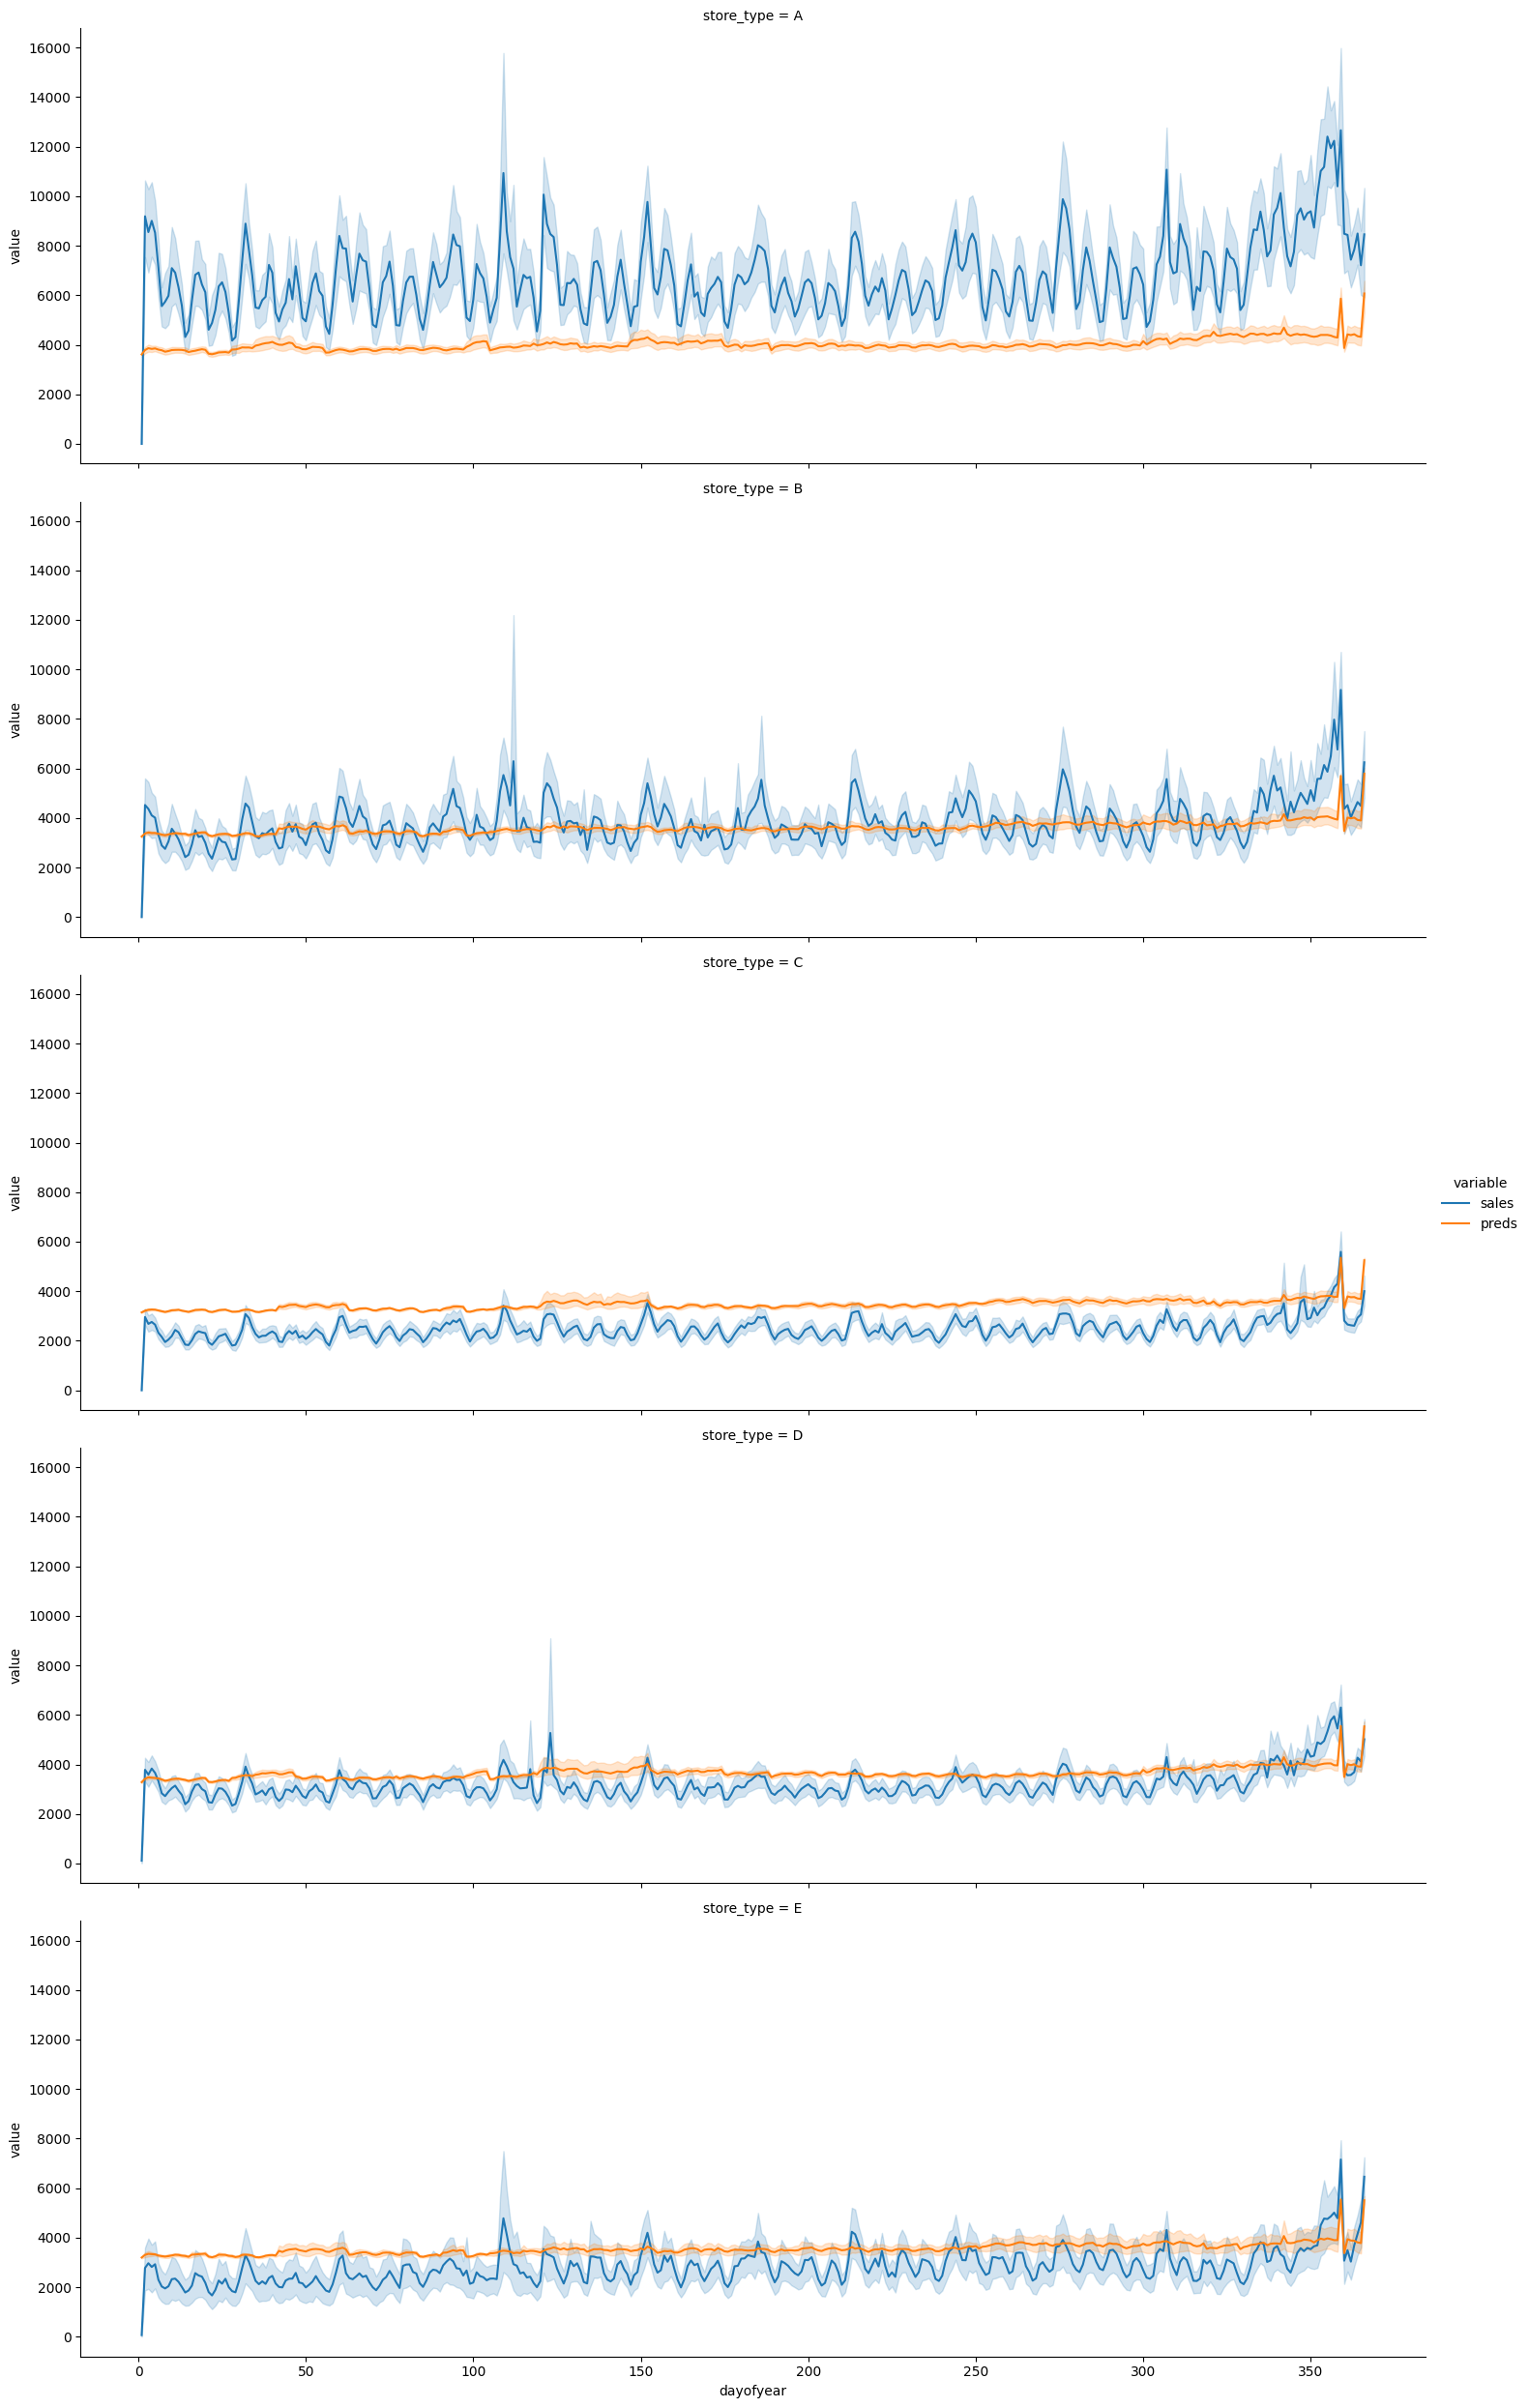

In [11]:
g = train.copy()
g['preds'] = y
g = g.query('family == "GROCERY I"')
g = g[['store_type', 'sales', 'preds', 'dayofyear']]
g = pd.melt(g, id_vars=['store_type', 'dayofyear'])

sns.relplot(g, x='dayofyear', y='value', hue='variable'
            , row='store_type', row_order=list('ABCDE')
            , kind='line', aspect=3);

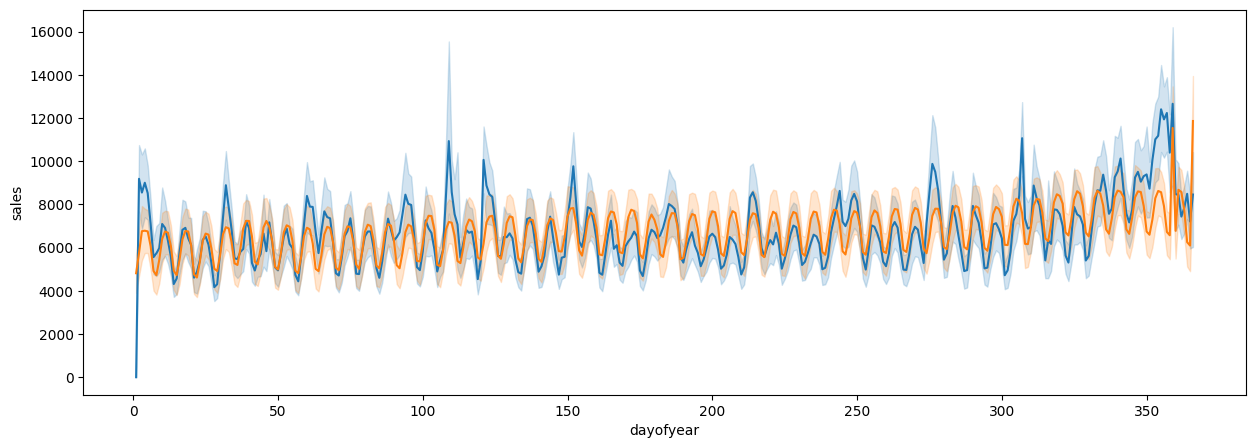

In [12]:
g = train.query('family == "GROCERY I"')
g = g.query('store_type == "A"')
# g = g.loc[g[target] != 0]
g_pp = pipe.transform(g)
g_model = LinearRegression()
g_model.fit(g_pp, g[target])
g['preds'] = g_model.predict(g_pp)

fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(data=g, x='dayofyear', y=target, ax=ax);
sns.lineplot(data=g, x='dayofyear', y='preds', ax=ax);

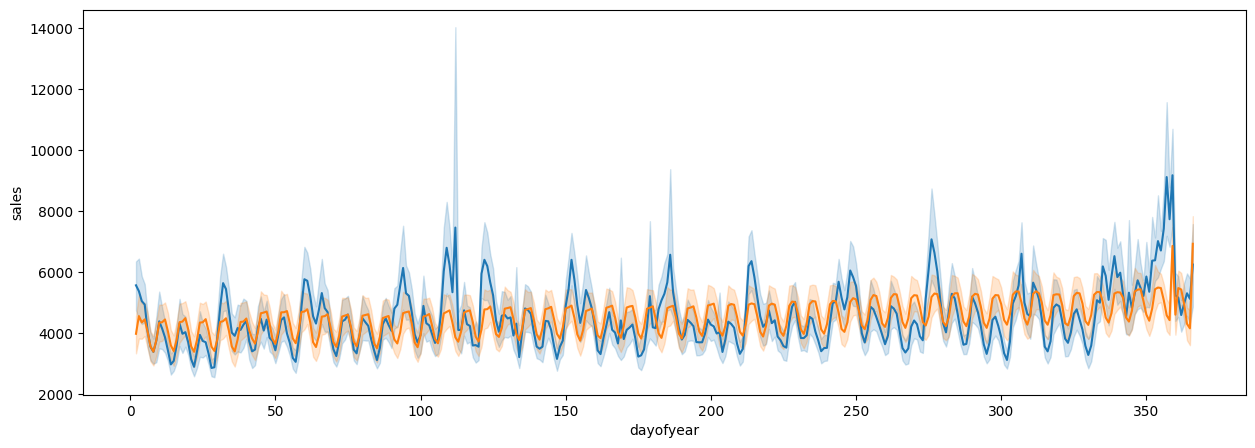

In [13]:
g = train.query('family == "GROCERY I"')
g = g.query('store_type == "B"')
g = g.loc[g[target] != 0]
g_pp = pipe.transform(g)
g_model = LinearRegression()
g_model.fit(g_pp, g[target])
g['preds'] = g_model.predict(g_pp)

fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(data=g, x='dayofyear', y=target, ax=ax);
sns.lineplot(data=g, x='dayofyear', y='preds', ax=ax);

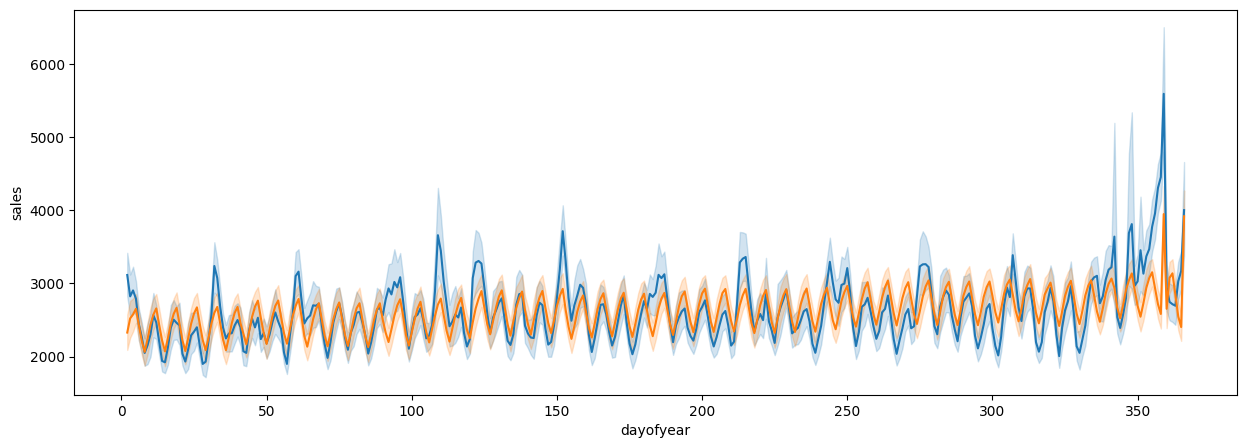

In [14]:
g = train.query('family == "GROCERY I"')
g = g.query('store_type == "C"')
g = g.loc[g[target] != 0]
g_pp = pipe.transform(g)
g_model = LinearRegression()
g_model.fit(g_pp, g[target])
g['preds'] = g_model.predict(g_pp)

fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(data=g, x='dayofyear', y=target, ax=ax);
sns.lineplot(data=g, x='dayofyear', y='preds', ax=ax);

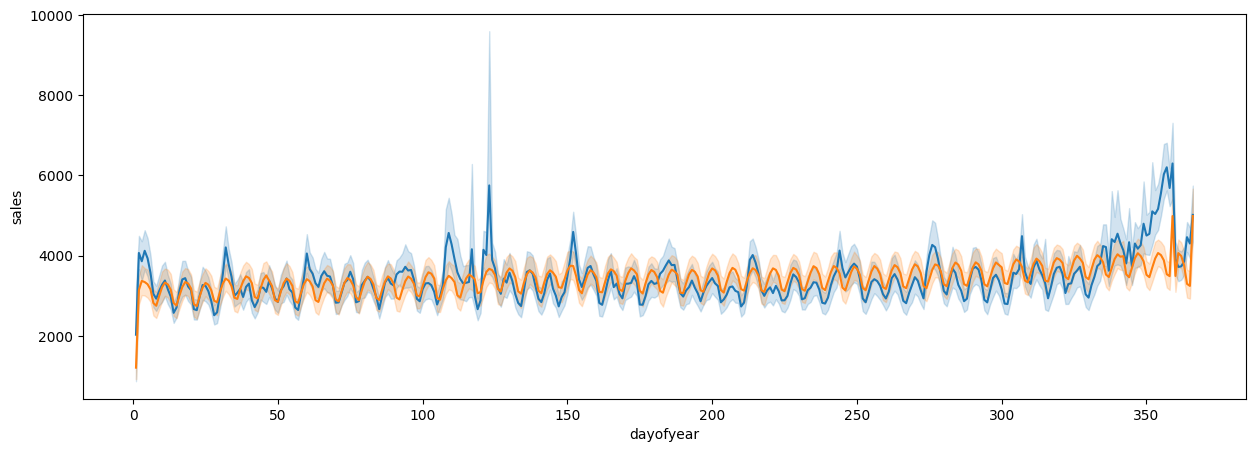

In [15]:
g = train.query('family == "GROCERY I"')
g = g.query('store_type == "D"')
g = g.loc[g[target] != 0]
g_pp = pipe.transform(g)
g_model = LinearRegression()
g_model.fit(g_pp, g[target])
g['preds'] = g_model.predict(g_pp)

fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(data=g, x='dayofyear', y=target, ax=ax);
sns.lineplot(data=g, x='dayofyear', y='preds', ax=ax);

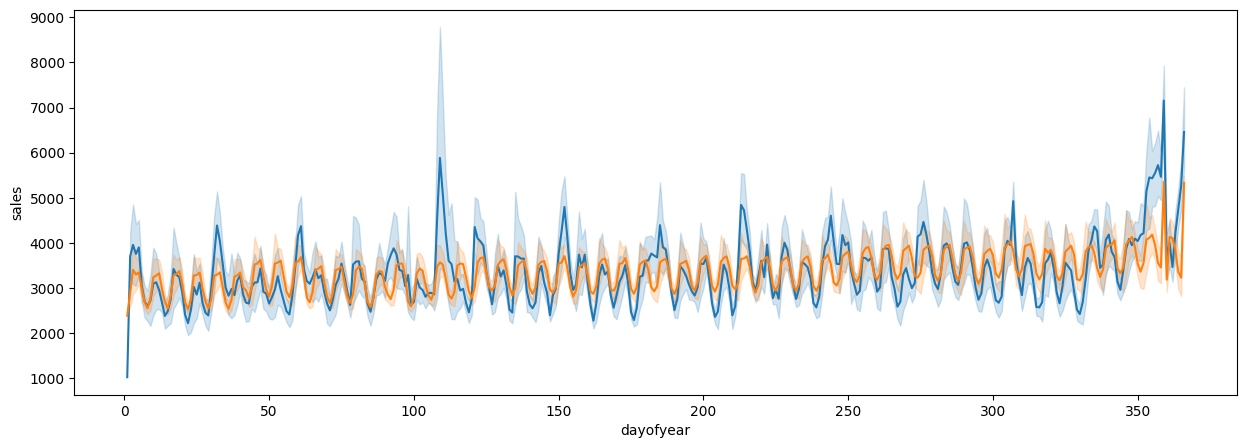

In [16]:
g = train.query('family == "GROCERY I"')
g = g.query('store_type == "E"')
g = g.loc[g[target] != 0]
g_pp = pipe.transform(g)
g_model = LinearRegression()
g_model.fit(g_pp, g[target])
g['preds'] = g_model.predict(g_pp)

fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(data=g, x='dayofyear', y=target, ax=ax);
sns.lineplot(data=g, x='dayofyear', y='preds', ax=ax);

# > Submission

In [17]:
samp = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv')
pd.DataFrame({
    'id': samp['id']
    , 'sales': reg_lin.predict(pipe.transform(samp))
}).to_csv('submission.csv', index=False)